In [1]:
import pandas as pd 
import numpy as np

In [2]:
import nltk
# nltk.download('all')# download nltk files
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from nltk.tokenize import sent_tokenize, word_tokenize 

In [3]:
import os 
import glob
import re
import time

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# %matplotlib inline


In [6]:
from sklearn.svm import SVC

In [7]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchnlp.nn as nlp_nn
import pandas as pd
import numpy as np
import string
import json
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
torch.manual_seed(1)
# from tensorflow import summary
import random
from torch.autograd import Variable
# import tensorflow as tf

In [8]:
def ap(y_pred,y_belong):
  y_pred = np.array(y_pred)
  y_belong = np.array(y_belong)
  y_pred = y_pred.reshape(-1,1)
  y_belong = y_belong.reshape(-1,1)
  arr = np.concatenate((y_pred,y_belong),axis=1)
  
  arr = sorted(arr,key = lambda x:x[0],reverse=True)
  
  ans = 0
  rel = 0
  num = 0
  for i in range(len(y_pred)):
    if arr[i][1] == 1:
      rel = rel+1
      ans += rel/(i+1)
      num = num+1
  return ans/num

In [9]:
def rem_stop(txt):
  return [ c for c in txt if c not in stopwords.words("english")]
stemmer = PorterStemmer()
def word_stemm(txt):
  return [stemmer.stem(w) for w in txt]

In [10]:
xl_files_train = glob.glob("./dataset/Task1/Train/*.xlsx")
xl_files_test = glob.glob("./dataset/Task1/Test/*.xlsx")

In [11]:
xl_files_test

['./dataset/Task1/Test/Loss.xlsx',
 './dataset/Task1/Test/Frustrative_Nonreward.xlsx',
 './dataset/Task1/Test/Sleep_Wakefulness.xlsx',
 './dataset/Task1/Test/Sustained_Threat.xlsx',
 './dataset/Task1/Test/Potential_Threat_Anxiety.xlsx',
 './dataset/Task1/Test/Circadian_Rhythms.xlsx',
 './dataset/Task1/Test/Arousal.xlsx',
 './dataset/Task1/Test/Acute_Threat_Fear.xlsx']

In [12]:
# create labels
labels = {}
revLabels = {}
for i,xl in  enumerate(xl_files_train):
    className = xl.split("/")[-1][:-5]
    labels[className] = i
    revLabels[i] = className

In [13]:
#train dataframes
frames = []
for xl_file in xl_files_train:
    df1 = pd.read_excel(xl_file)
    className = xl_file.split("/")[-1][:-5]
    df1['Y'] = labels[className]
    frames.append(df1)
df_train = pd.concat(frames,ignore_index = True)

In [14]:
#test dataframes
frames = []
for xl_file in xl_files_test:
    df1 = pd.read_excel(xl_file)
    className = xl_file.split("/")[-1][:-5]
    df1['Y'] = labels[className]
    frames.append(df1)
df_test = pd.concat(frames,ignore_index = True)

In [15]:
PUNC_LIST = string.punctuation + string.digits
TOKENIZER = re.compile(r"\w+")
def clean_text(text):
    """
        Removes non-alphabetic characters
    """
    #remove new line and carriage with space
    text = text.replace("\n"," ").replace("\r"," ")
    tmp = str.maketrans(dict.fromkeys(PUNC_LIST," "))
    text = text.translate(tmp)
    # replace single quote with empty 
    tmp  = str.maketrans(dict.fromkeys("'`",""))
    return text.translate(tmp)
def regexTokenize(text):

    return TOKENIZER.findall(clean_text(text))

In [273]:
# pre process the text
stop_words = stopwords.words("english")
def stem(w):
#     return w.lower()
    return stemmer.stem(w)#.lower()
cols = ['title','abstract']
for col in cols :
    df_train['c_'+col] = df_train[col].apply(lambda x: " ".join([stem(i) for i in regexTokenize(x) if i not in stop_words]))
    df_test['c_'+col] = df_test[col].apply(lambda x: " ".join([stem(i) for i in regexTokenize(x) if i not in stop_words]))

In [274]:
# concatenate the entire text
df_train['inp'] =  df_train['c_title'] + df_train['c_abstract']
df_test['inp'] = df_test['c_title']  + df_test['c_abstract']
# c_title = df_train[['c_title','pmid']].values

In [275]:
x_train = df_train['inp'].values

In [276]:
tfidf = TfidfVectorizer()#, tokenizer=regexTokenize)

In [277]:
df_test.columns 

Index(['pmid', 'title', 'abstract', 'Belongs to RDoC construct?',
       'Relevant Context', 'Y', 'c_title', 'c_abstract', 'inp', 'Belongs'],
      dtype='object')

In [278]:
# frequency analysis
voc = {}
for row in x_train:
    for w in row.split():
        if w in voc : 
            voc[w] += 1
        else:
            voc[w] = 1

In [279]:
freqList = []
v= 1000
label = []
for k in voc.keys():
        freqList.append(voc[k])
        label.append(k)
        if voc[k] > 400:
            print(k,voc[k])

sleep 513


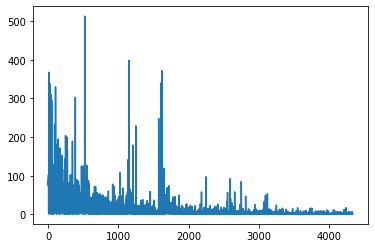

In [280]:
plt.plot(freqList)

In [281]:
x_train = tfidf.fit_transform(x_train).toarray()

In [282]:
y_train = df_train['Y'].values

In [283]:
x_test = df_test['inp'].values
x_test = tfidf.transform(x_test).toarray()
df_test['Belongs'] = df_test['Belongs to RDoC construct?']

In [284]:
# gdf.groups
gdf = df_test.groupby('Y')
construct_test = {}
for i in range(8):
  construct_test[i]= df_test.iloc[gdf.groups[i]]

In [285]:
cw = [28,21,48,18,27,47,38,39]
ncw = [ np.exp(-(i/sum(cw))) for i in cw]
tcw = [ np.exp((i/sum(cw))) for i in cw]
sftmax = { i:e/ sum(ncw) for i,e in enumerate(ncw)}
tsftmax = { i:e/ sum(tcw) for i,e in enumerate(tcw)}
siminv={ i:e/ sum(cw) for i,e in enumerate(cw)}

In [295]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |      Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a 

In [297]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimator=200,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [286]:
# # USING RANDOM FOREST CLASSIFIER
# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(bootstrap=True,n_estimators=200,criterion="gini",random_state = 47,max_depth = 3,class_weight=siminv)
# svmc = SVC(gamma = 0.01,C= 0.25,probability = True,shrinking =True,class_weight=tsftmax,break_ties=True, kernel="rbf"  ,decision_function_shape = 'ovr',random_state = 47)

In [302]:
# USING RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimator=200)
rfc = RandomForestClassifier(bootstrap=True,oob_score = True,n_estimators=200,criterion="gini",random_state = 47,max_depth = 3,class_weight=siminv)
svmc = SVC(gamma = 0.1512,C= 0.25,probability = True,shrinking =True,class_weight=tsftmax,break_ties=True, kernel="rbf"  ,decision_function_shape = 'ovr',random_state = 47)
map_list = []
estimators = [rfc,svmc,xgb]
for model in estimators:
    print(model.fit(x_train, y_train))
class_count = {}
err = {}
for i,model in enumerate(estimators):
  aps = 0
  err[i] = {}
  for cl_ in construct_test.keys():
    X_test = tfidf.transform(construct_test[cl_]['inp']).toarray()
    y_pred = model.predict_proba(X_test)[:,cl_]
    y_belongs = np.array(construct_test[cl_]['Belongs'].values).reshape(len(X_test),1)
    t = ap(y_pred,y_belongs)
    err[i][cl_] = round( t, 2)
    aps += t
  print("=====")
  map_list.append(round(aps/8,2))
print("MAP",list(map(lambda x:round(x,5),map_list)))
st = "Class Name\t\t\t"+ "\t\t".join([str(i) for i  in range(len(err.keys()))])
print(st)
for cl_ in construct_test.keys():
    padd = "\t\t"
    if len(revLabels[cl_]) < 15:
        padd += "\t\t"
    if len(revLabels[cl_]) > 22:
        padd = "\t"
    st = revLabels[cl_]+padd+"\t\t".join([ str(round(err[j][cl_],4)) for j in range(len(err.keys()))])
    print(st)
        

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.10526315789473684,
                                     1: 0.07894736842105263,
                                     2: 0.18045112781954886,
                                     3: 0.06766917293233082,
                                     4: 0.10150375939849623,
                                     5: 0.17669172932330826,
                                     6: 0.14285714285714285,
                                     7: 0.14661654135338345},
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=47, verbose=0,
                       warm_st

In [164]:

st = "Class Name\t\t\t"+ "\t\t".join([str(i) for i  in range(len(err.keys()))])
print(st)
for cl_ in construct_test.keys():
    padd = "\t\t"
    if len(revLabels[cl_]) < 15:
        padd += "\t\t"
    if len(revLabels[cl_]) > 22:
        padd = "\t"
    st = revLabels[cl_]+padd+"\t\t".join([ str(round(err[j][cl_],3)) for j in range(len(err.keys()))])
    print(st)
        

Class Name			0		1
Loss				0.765		0.75
Frustrative_Nonreward		0.681		0.668
Sleep_Wakefulness		0.998		1.0
Sustained_Threat		0.62		0.642
Potential_Threat_Anxiety	0.947		0.969
Circadian_Rhythms		1.0		1.0
Arousal				0.939		0.946
Acute_Threat_Fear		0.819		0.811


In [60]:
for i,p in tgdf:
    print(i,p.count()['pmid'])

0 28
1 21
2 48
3 18
4 27
5 47
6 38
7 39


In [107]:
cw = [28,21,48,18,27,47,38,39]
ncw = [ np.exp(-(i/sum(cw))) for i in cw]
sftmax = [ i/ sum(ncw) for i in ncw]
siminv=[i / sum(cw) for i in cw]

In [119]:
print(siminv)
print(sftmax)

[0.10526315789473684, 0.07894736842105263, 0.18045112781954886, 0.06766917293233082, 0.10150375939849623, 0.17669172932330826, 0.14285714285714285, 0.14661654135338345]
[0.1273890713305995, 0.13078591458923697, 0.11816216813492254, 0.13226929289290032, 0.12786887894270862, 0.118607222856982, 0.12268891092970848, 0.12222854032294164]


In [90]:
for i,imp in enumerate(rfc.feature_importances_):
    print(i,imp)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0002081564208924825
5 0.00017589262183683403
6 0.00016264738867688934
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0001786146927632235
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0008713714195484803
53 0.0
54 0.00010365794469781649
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 8.258812117069163e-05
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.000101110179532024
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0017002638527223886
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0001018812249580364


1177 0.0
1178 0.0
1179 0.0
1180 0.0
1181 0.0008381900751637759
1182 0.0
1183 0.000159519379329444
1184 0.0
1185 0.0
1186 0.0
1187 0.00013763751640626768
1188 0.0011662505485458467
1189 0.00031965618192508104
1190 0.0001291433454903976
1191 0.0
1192 0.0
1193 0.0
1194 0.0
1195 0.0
1196 0.0
1197 0.0
1198 0.0
1199 0.0
1200 0.0
1201 0.0
1202 0.0
1203 0.0
1204 0.0
1205 0.0
1206 0.0
1207 0.0
1208 0.0
1209 0.0
1210 0.0
1211 0.0
1212 0.0
1213 0.0
1214 0.0
1215 0.0
1216 0.0
1217 0.0
1218 0.0
1219 0.0
1220 0.0
1221 0.0
1222 0.0
1223 0.0
1224 0.0
1225 0.0
1226 0.0
1227 0.0
1228 0.0
1229 0.0
1230 0.0
1231 0.00023695899534260478
1232 0.0
1233 0.0
1234 0.0004179250901034959
1235 0.0
1236 0.0
1237 0.0
1238 0.0
1239 0.0
1240 0.0
1241 0.0004931732500818325
1242 0.0
1243 0.0
1244 0.0
1245 0.0
1246 0.0
1247 0.0
1248 0.0
1249 0.0
1250 0.0
1251 0.0
1252 0.0
1253 0.0
1254 0.0
1255 0.0
1256 0.0
1257 0.0021725424622257338
1258 0.0
1259 0.0
1260 0.0
1261 0.0
1262 0.0
1263 0.0
1264 0.0
1265 0.0
1266 0.0
1267 0.0

2176 0.0
2177 6.102613943250649e-05
2178 0.0
2179 0.0
2180 0.0
2181 0.0
2182 0.00029659861870792823
2183 0.0
2184 0.0
2185 0.0
2186 0.0
2187 0.0
2188 0.001187528102568844
2189 0.0
2190 0.0
2191 0.0
2192 0.0014024372045977989
2193 0.0
2194 0.0
2195 0.0
2196 0.0
2197 0.0
2198 0.01025313640761885
2199 0.0
2200 0.00027184735398628085
2201 0.0
2202 0.0
2203 0.0
2204 0.0
2205 0.0
2206 0.0006392670860781357
2207 0.0
2208 0.00023549510604466478
2209 0.0017765649492383026
2210 0.0
2211 0.0
2212 0.0
2213 0.0
2214 0.0
2215 0.0
2216 0.0
2217 0.0
2218 0.0
2219 0.0
2220 0.0
2221 0.0
2222 0.0
2223 0.0
2224 0.0
2225 0.0
2226 0.0
2227 0.0
2228 0.0
2229 0.0
2230 0.0
2231 0.0
2232 0.0
2233 0.0
2234 0.0
2235 0.0
2236 0.0001835399852335474
2237 0.00029513526301744184
2238 0.0016039385329126767
2239 0.0
2240 0.0
2241 0.0
2242 0.0
2243 0.0
2244 0.0
2245 0.0
2246 0.0
2247 0.01090923677151064
2248 0.0
2249 0.0
2250 0.0
2251 0.0
2252 0.0
2253 0.0012192647798269973
2254 0.001160951585121169
2255 0.0
2256 0.0
225

3318 0.0
3319 0.0
3320 0.0
3321 0.0
3322 0.01811126825892226
3323 0.0
3324 0.0
3325 0.0
3326 0.0
3327 0.0
3328 0.0
3329 0.0
3330 0.003445801245906342
3331 0.0
3332 0.0
3333 0.0
3334 0.0
3335 0.0
3336 0.0
3337 0.0
3338 0.0
3339 0.0
3340 0.0
3341 0.0
3342 0.0
3343 0.0
3344 0.0
3345 0.0
3346 0.0018693916035321637
3347 0.0
3348 0.0006394690689172571
3349 0.0
3350 0.0
3351 0.0
3352 0.0
3353 0.0
3354 0.0
3355 0.0
3356 0.0
3357 0.0
3358 0.026067888536398715
3359 0.0
3360 0.0
3361 0.0
3362 0.0
3363 0.0
3364 0.0
3365 0.007150020068380845
3366 0.0
3367 0.0
3368 0.0
3369 0.0
3370 0.0
3371 0.0008019964010978704
3372 0.0
3373 0.0
3374 0.0
3375 0.0
3376 0.0
3377 0.0
3378 0.0
3379 0.0
3380 0.0010935955366229459
3381 0.0004534703510252506
3382 0.0
3383 0.0
3384 0.0
3385 0.0
3386 0.0
3387 0.0
3388 0.0
3389 0.0
3390 0.0
3391 0.0
3392 0.0
3393 0.0
3394 0.00012026748540447125
3395 0.0
3396 0.0
3397 0.0
3398 0.0
3399 0.0
3400 0.0
3401 0.0
3402 0.0
3403 0.0
3404 0.0
3405 0.001904941395989879
3406 0.00070189

In [98]:
map_list = []
class_count = {}
for _ in range(1):
  aps = 0
  for cl_ in construct_test.keys():
    X_test = construct_test[cl_]['inp2'].apply(toTensor).values
    y_pred = torch.randn((len(X_test),1)).to(device)
    class_count[cl_] = len(X_test)
    for i in range(len(X_test)):
      y_pred[i] = model(X_test[i].to(device))[cl_,0].reshape(1,1)
    y_pred = y_pred.cpu().detach().numpy()
    # print(y_pred.shape)
    y_belongs = np.array(construct_test[cl_]['Belongs'].values).reshape(len(X_test),1)
    # print(y_belongs.shape)
    # print(np.concatenate((y_belongs,y_pred),axis =1 ))
    t = ap(y_pred,y_belongs)
    print(labels[cl_],t)
    aps += t
  # println()
  map_list.append(aps/8)
  # break


KeyError: 0

In [ ]:
def ap(y_pred,y_belong):
  y_pred = np.array(y_pred)
  y_belong = np.array(y_belong)
  y_pred = y_pred.reshape(-1,1)
  y_belong = y_belong.reshape(-1,1)
  arr = np.concatenate((y_pred,y_belong),axis=1)
  
  arr = sorted(arr,key = lambda x:x[0],reverse=True)
  
  ans = 0
  rel = 0
  num = 0
  for i in range(len(y_pred)):
    if arr[i][1] == 1:
      rel = rel+1
      ans += rel/(i+1)
      num = num+1
  return ans/num

def map(y_pred,y,y_belong):
  j = 0
  j_prev = 0
  ans = 0
  for i in range(8):
    while j<len(y) and y[j] == i:
      j = j+1
    ans = ans + ap(y_pred[j_prev:j],y_belong[j_prev:j])
    j_prev = j
  return ans/8
